# 04. PyTorch Custom Dataset

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch

One of the ways to do so is via: custom datasets

## Domain libraries

Depending on what you're working onm vision, text, audiom recommendation, you'll want to look into each of PyTorch domain libraries for existing data loading functions and customizable data loading functions

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device agnostic code

In [106]:
import torch
from torch import nn
import requests
import zipfile
import pathlib
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, dataset
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
import tqdm
from tqdm.auto import tqdm

In [54]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset od Food101 dataset.
Food101 starts 101 different classes of food and 1000 images per class (750 training and 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75% training, 25% testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [55]:
# import requests, zipfile, Path from pathlib

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn's exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists, skipping download...")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suchi data...")
  f.write(request.content)

# Unzip pizza, steam, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists, skipping download...
Unzipping pizza, steak, sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [56]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirname, filename in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

In [57]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [58]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, lets's open the images wiht Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/3109486.jpg
Image class: pizza
Image height: 512
image width: 512


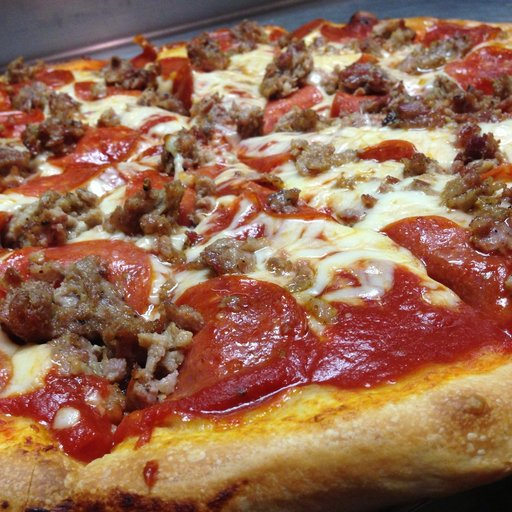

In [59]:
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # the 1st star is for train/test, 2nd is for pizza/steak/sushi, 3rd is to combine the same imagees together

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
# 3. Get the image class from path name(the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

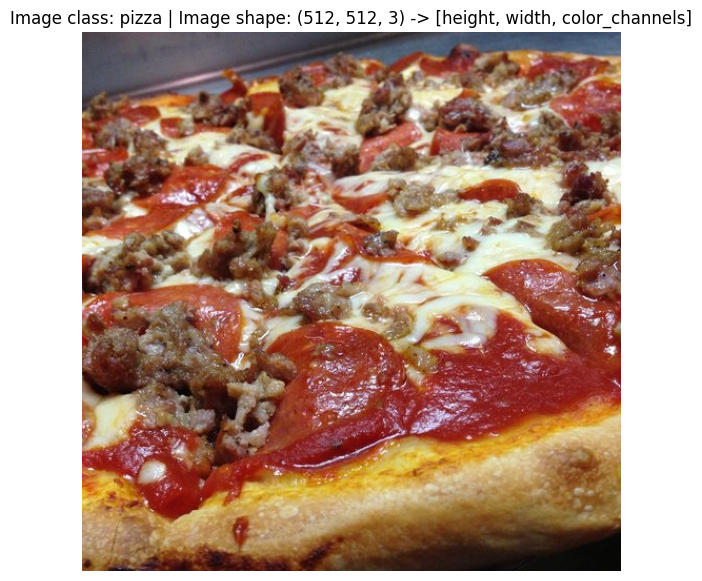

In [60]:
img_as_array = np.asarray(img)

plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images)
2. Turn in into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

### 3.1 Transforming data with `torchvision.transforms`

In [61]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size = (64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

In [62]:
data_transform(img).dtype

torch.float32

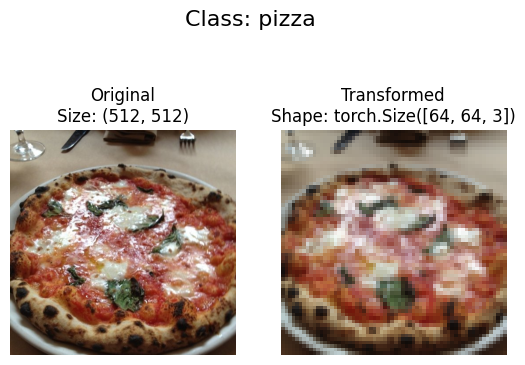

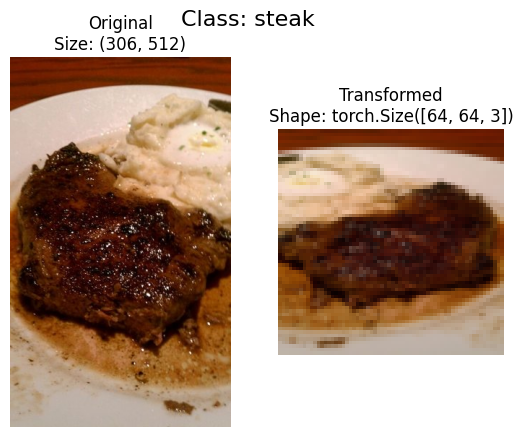

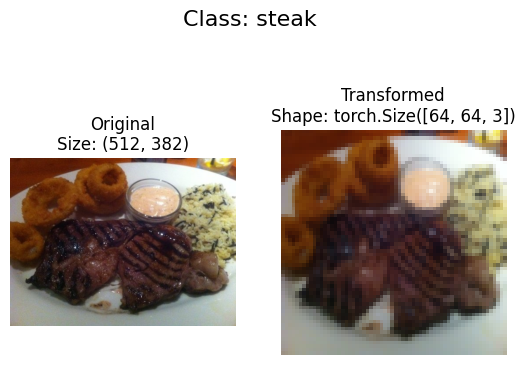

In [63]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = 42):
  """
  Selects random images from a path of images and loads/transforms them, then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = 3)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note, we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n = 3,
                        seed = 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [64]:
# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform = None) # a transform for the label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [65]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [66]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [67]:
len(train_data), len(test_data)

(225, 75)

In [68]:
# Index on the train_data Dataset to get single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

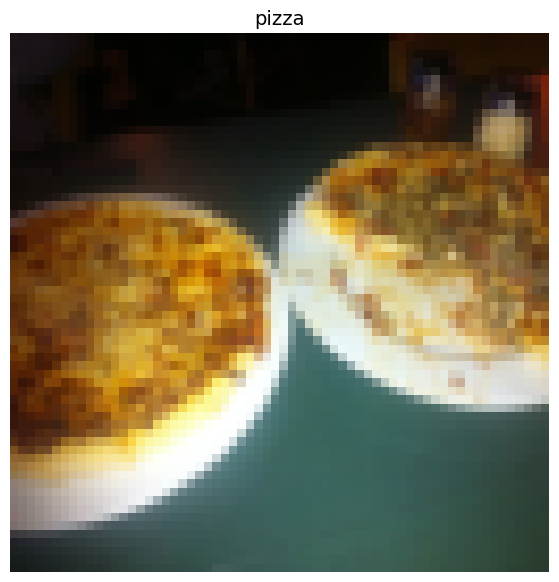

In [69]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize = 14)
plt.axis(False)

### 4.1 Turn loaded Images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [70]:
BATCH_SIZE = 1

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = 1,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = 1,
    shuffle = False
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bd45d64e270>,
 <torch.utils.data.dataloader.DataLoader at 0x7bd44f037ce0>)

In [71]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

**Pros:**
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-build `Dataset` functions.

**Cons:**
* Even though you could create `Dataset` out of almost anything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch often subclass `dataset` from `torch.utils.data`

In [72]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class name using `os.scandir()` to traverse a target directory (ideally the directort is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into dict and a list and return them.

In [73]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [74]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [75]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_id - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `___getitem__()` method to return a given sample when passed an index

In [76]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custim dataset
  def __init__(self,
              targ_dir: str,
              transform = None):
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class to idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Open an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # 6. Overwrite__getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # retunr untransformed image and label

In [77]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [78]:
train_transforms, test_transforms

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [79]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [80]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7bd44eff8350>,
 <__main__.ImageFolderCustom at 0x7bd44eff8a10>)

In [81]:
len(train_data), len(train_data_custom)

(225, 225)

In [82]:
len(test_data), len(test_data_custom)

(75, 75)

In [83]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [84]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [85]:
# Check fo equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, cap the number of images to see at 10.
3. Set the random seed for reproducinility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our image line up with matplotlib (HWC)

In [86]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape =  False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k = n) # between 0 and 255 of out train_data_custom we are going to get 10 random indexes

  # 5. Setup plot
  plt.figure(figsize = (16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

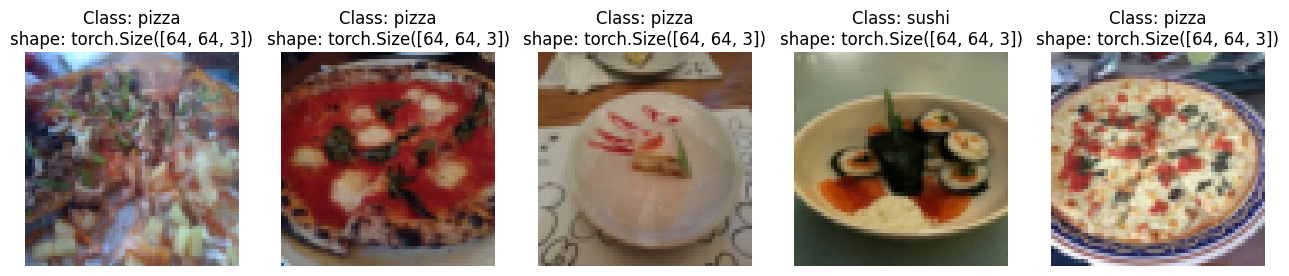

In [87]:
# Display random images from ImageFolder
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


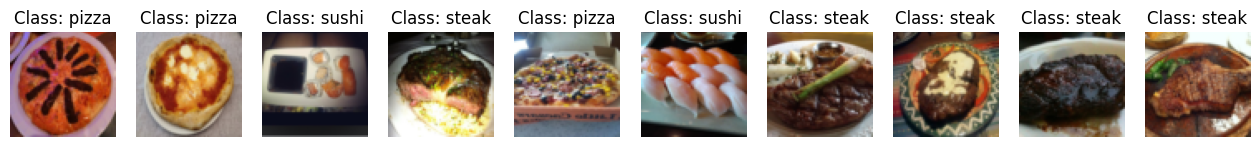

In [88]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n = 20,
                      classes = class_names,
                      seed = None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [89]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7bd46a934bc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bd44d798170>)

In [90]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transform (Augmentation)

Data augmentation is the process of artificillay adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practise hopefully results in a model that is more generalizable to unsees data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [91]:
# Let's look into trivalaugment
train_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

In [92]:
image_path

PosixPath('data/pizza_steak_sushi')

In [93]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]

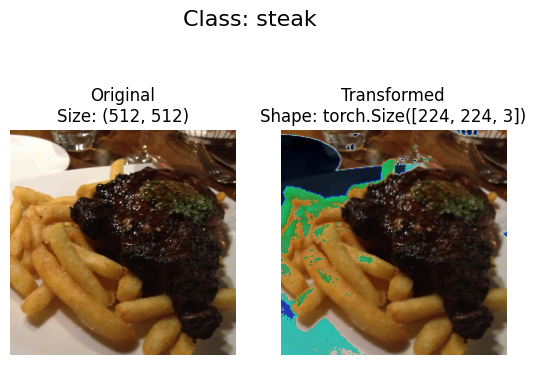

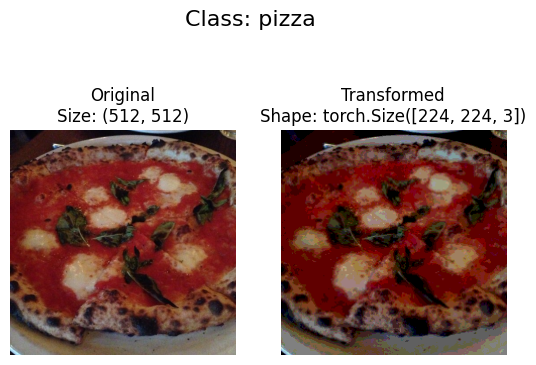

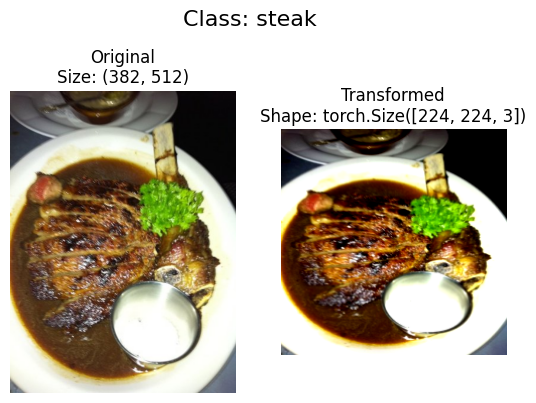

In [94]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n = 3,
    seed = None
)

## 7. Model 0: TinyVGG withput data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website:
https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [95]:
# Create  simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [96]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                       transform = simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [97]:
class TinyVGG(nn.Module):
  """Model architecture copying TinyVGG from CNN Explainer"""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2) # for Maxpool2d, stride value is same to that of kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2) # for Maxpool2d, stride value is same to that of kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self, x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [98]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels in our image data
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image(to test out the model)

In [99]:
# Get single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [100]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [101]:
# Install torchinfi, since it is not available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [102]:
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [104]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dataloader data batches
  for batch, (X, y) in enumerate(data_loader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer the zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Caculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class ==y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss an accuracy per batch
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  return train_loss, train_acc

In [105]:
# Create a test step
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module,
              device = device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Trun on inference mode
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_logits))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(data_loader)
  test_acc = test_acc / len(data_loader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [108]:
# 1. Create a train function in various model parameters + optimizer + dataloaders + loss_function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       data_loader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    # 4. Print put what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc: .4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results